In [2]:
import gjp
import statistics
import numpy as np
import pandas as pd
import iqisa as iqs

In [3]:
m=gjp.Markets()
m.load()
s=gjp.Surveys()
s.load()

/home/niplav/proj/iqisa/gjp.py:46: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  self.load_complete(files)
/usr/lib/python3/dist-packages/dateutil/parser/_parser.py:1199: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/usr/lib/python3/dist-packages/dateutil/parser/_parser.py:1199: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
/home/niplav/proj/iqisa/gjp.py:46: DtypeWarning: Columns (6,7,9,21) have mixed types.Specify dtype option on import or set low_memory=False.
  self.load_complete(files)


In [4]:
print(m.forecasts.shape)
print(m.questions.shape)
print(s.forecasts.shape)
print(s.questions.shape)

(735432, 15)
(617, 14)
(3143460, 15)
(617, 14)


In [5]:
def brier_score(probabilities, outcomes, *args):
        return np.mean((probabilities-outcomes)**2)

trader_scores=iqs.score(m.forecasts, brier_score, on=['user_id'])
filtered_trader_scores=iqs.score(m.forecasts.groupby(['user_id']).filter(lambda x: len(x)>100), brier_score, on=['user_id'])
highly_filtered_trader_scores=iqs.score(m.forecasts.groupby(['user_id']).filter(lambda x: len(x)>1000), brier_score, on=['user_id'])

In [6]:
print(trader_scores.describe())
print(filtered_trader_scores.describe())
print(highly_filtered_trader_scores.describe())

             score
count  2404.000000
mean      0.160547
std       0.084879
min       0.000100
25%       0.116689
50%       0.150936
75%       0.186568
max       0.792100
            score
count  929.000000
mean     0.158090
std      0.053332
min      0.018641
25%      0.128133
50%      0.156140
75%      0.179822
max      0.722772
            score
count  130.000000
mean     0.148736
std      0.038856
min      0.042081
25%      0.125740
50%      0.148640
75%      0.172906
max      0.248622


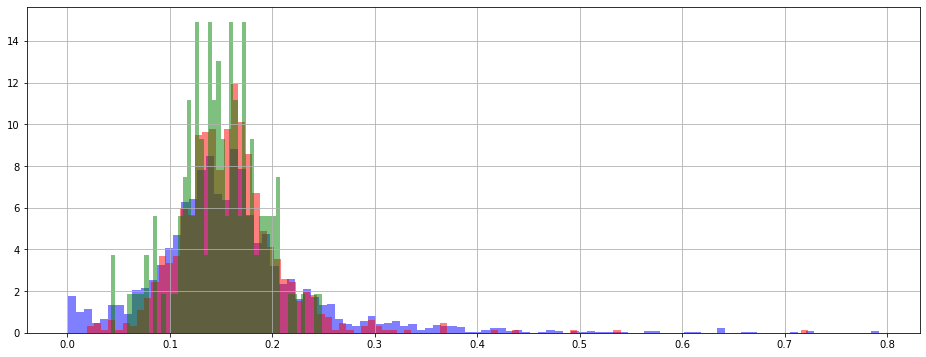

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,6))
plt.hist(trader_scores['score'], bins=100, density=True, alpha=0.5, align='mid', color='blue')
plt.hist(filtered_trader_scores['score'], bins=100, density=True, alpha=0.5, align='mid', color='red')
plt.hist(highly_filtered_trader_scores['score'], bins=50, density=True, alpha=0.5, align='mid', color='green')
plt.grid()

### Different Analyses

When wanting to know how well groups of forecasters perform, we can perform different kinds of analyses, with different kinds of aggregated parts of the dataset.

1. We score forecasters, and sort them by their score.
2. We randomly choose groups of forecasters of size $2 \le i \le n$ (for some maximal $n$) and then compute the score of those groups. On average, what percentile of forecaster performance does a group of size $i$ find itself in?
    1. We also aggregate the forecasts from those groups in a smarter way.
3. We score teams of forecasters and find out what percentile of forecaster performance each team finds themselves in.
    1. We also aggregate the forecasts from those teams in a smarter way.

In [8]:
max_group_size=100
sample_size=100
groups=[np.random.choice(np.unique(m.forecasts['user_id']), size=(sample_size, i)) for i in range(2, max_group_size)]

In [9]:
def geom_odds_aggr(forecasts):
    probabilities=forecasts['probability']
    probabilities=probabilities/(1-probabilities)
    aggregated=statistics.geometric_mean(probabilities)
    aggregated=aggregated/(1+aggregated)
    return np.array([aggregated])

In [10]:
all_group_scores=pd.DataFrame(columns=['size', 'score', 'aggregated'])
for i in range(0, max_group_size-2):
    for group in groups[i]:
        group_table=pd.DataFrame({'user_id': group})
        group_forecasts=pd.merge(m.forecasts, group_table, on=['user_id'], how='inner')
        aggregated_group_forecasts=iqs.aggregate(group_forecasts, geom_odds_aggr)
        group_scores=iqs.score(group_forecasts, brier_score)['score']
        aggregated_group_scores=iqs.score_aggregations(aggregated_group_forecasts, brier_score)['score']
        group_score=np.mean(group_scores)
        aggregated_group_score=np.mean(aggregated_group_scores)
        nf=pd.DataFrame({'size': [i+2, i+2], 'score': [group_score, aggregated_group_score], 'aggregated': [False, True]})
        all_group_scores=pd.concat([all_group_scores, nf])

(2, 3)
(4, 3)
(6, 3)
(8, 3)
(10, 3)
(12, 3)
(14, 3)
(16, 3)
(18, 3)
(20, 3)
(22, 3)
(24, 3)
(26, 3)
(28, 3)
(30, 3)
(32, 3)
(34, 3)
(36, 3)
(38, 3)
(40, 3)
(42, 3)
(44, 3)
(46, 3)
(48, 3)
(50, 3)
(52, 3)
(54, 3)
(56, 3)
(58, 3)
(60, 3)
(62, 3)
(64, 3)
(66, 3)
(68, 3)
(70, 3)
(72, 3)
(74, 3)
(76, 3)
(78, 3)
(80, 3)
(82, 3)
(84, 3)
(86, 3)
(88, 3)
(90, 3)
(92, 3)
(94, 3)
(96, 3)
(98, 3)
(100, 3)
(102, 3)
(104, 3)
(106, 3)
(108, 3)
(110, 3)
(112, 3)
(114, 3)
(116, 3)
(118, 3)
(120, 3)
(122, 3)
(124, 3)
(126, 3)
(128, 3)
(130, 3)
(132, 3)
(134, 3)
(136, 3)
(138, 3)
(140, 3)
(142, 3)
(144, 3)
(146, 3)
(148, 3)
(150, 3)
(152, 3)
(154, 3)
(156, 3)
(158, 3)
(160, 3)
(162, 3)
(164, 3)
(166, 3)
(168, 3)
(170, 3)
(172, 3)
(174, 3)
(176, 3)
(178, 3)
(180, 3)
(182, 3)
(184, 3)
(186, 3)
(188, 3)
(190, 3)
(192, 3)
(194, 3)
(196, 3)
(198, 3)
(200, 3)
(202, 3)
(204, 3)
(206, 3)
(208, 3)
(210, 3)
(212, 3)
(214, 3)
(216, 3)
(218, 3)
(220, 3)
(222, 3)
(224, 3)
(226, 3)
(228, 3)
(230, 3)
(232, 3)
(234, 3)


(1752, 3)
(1754, 3)
(1756, 3)
(1758, 3)
(1760, 3)
(1762, 3)
(1764, 3)
(1766, 3)
(1768, 3)
(1770, 3)
(1772, 3)
(1774, 3)
(1776, 3)
(1778, 3)
(1780, 3)
(1782, 3)
(1784, 3)
(1786, 3)
(1788, 3)
(1790, 3)
(1792, 3)
(1794, 3)
(1796, 3)
(1798, 3)
(1800, 3)
(1802, 3)
(1804, 3)
(1806, 3)
(1808, 3)
(1810, 3)
(1812, 3)
(1814, 3)
(1816, 3)
(1818, 3)
(1820, 3)
(1822, 3)
(1824, 3)
(1826, 3)
(1828, 3)
(1830, 3)
(1832, 3)
(1834, 3)
(1836, 3)
(1838, 3)
(1840, 3)
(1842, 3)
(1844, 3)
(1846, 3)
(1848, 3)
(1850, 3)
(1852, 3)
(1854, 3)
(1856, 3)
(1858, 3)
(1860, 3)
(1862, 3)
(1864, 3)
(1866, 3)
(1868, 3)
(1870, 3)
(1872, 3)
(1874, 3)
(1876, 3)
(1878, 3)
(1880, 3)
(1882, 3)
(1884, 3)
(1886, 3)
(1888, 3)
(1890, 3)
(1892, 3)
(1894, 3)
(1896, 3)
(1898, 3)
(1900, 3)
(1902, 3)
(1904, 3)
(1906, 3)
(1908, 3)
(1910, 3)
(1912, 3)
(1914, 3)
(1916, 3)
(1918, 3)
(1920, 3)
(1922, 3)
(1924, 3)
(1926, 3)
(1928, 3)
(1930, 3)
(1932, 3)
(1934, 3)
(1936, 3)
(1938, 3)
(1940, 3)
(1942, 3)
(1944, 3)
(1946, 3)
(1948, 3)
(1950, 3)


(3392, 3)
(3394, 3)
(3396, 3)
(3398, 3)
(3400, 3)
(3402, 3)
(3404, 3)
(3406, 3)
(3408, 3)
(3410, 3)
(3412, 3)
(3414, 3)
(3416, 3)
(3418, 3)
(3420, 3)
(3422, 3)
(3424, 3)
(3426, 3)
(3428, 3)
(3430, 3)
(3432, 3)
(3434, 3)
(3436, 3)
(3438, 3)
(3440, 3)
(3442, 3)
(3444, 3)
(3446, 3)
(3448, 3)
(3450, 3)
(3452, 3)
(3454, 3)
(3456, 3)
(3458, 3)
(3460, 3)
(3462, 3)
(3464, 3)
(3466, 3)
(3468, 3)
(3470, 3)
(3472, 3)
(3474, 3)
(3476, 3)
(3478, 3)
(3480, 3)
(3482, 3)
(3484, 3)
(3486, 3)
(3488, 3)
(3490, 3)
(3492, 3)
(3494, 3)
(3496, 3)
(3498, 3)
(3500, 3)
(3502, 3)
(3504, 3)
(3506, 3)
(3508, 3)
(3510, 3)
(3512, 3)
(3514, 3)
(3516, 3)
(3518, 3)
(3520, 3)
(3522, 3)
(3524, 3)
(3526, 3)
(3528, 3)
(3530, 3)
(3532, 3)
(3534, 3)
(3536, 3)
(3538, 3)
(3540, 3)
(3542, 3)
(3544, 3)
(3546, 3)
(3548, 3)
(3550, 3)
(3552, 3)
(3554, 3)
(3556, 3)
(3558, 3)
(3560, 3)
(3562, 3)
(3564, 3)
(3566, 3)
(3568, 3)
(3570, 3)
(3572, 3)
(3574, 3)
(3576, 3)
(3578, 3)
(3580, 3)
(3582, 3)
(3584, 3)
(3586, 3)
(3588, 3)
(3590, 3)


(5032, 3)
(5034, 3)
(5036, 3)
(5038, 3)
(5040, 3)
(5042, 3)
(5044, 3)
(5046, 3)
(5048, 3)
(5050, 3)
(5052, 3)
(5054, 3)
(5056, 3)
(5058, 3)
(5060, 3)
(5062, 3)
(5064, 3)
(5066, 3)
(5068, 3)
(5070, 3)
(5072, 3)
(5074, 3)
(5076, 3)
(5078, 3)
(5080, 3)
(5082, 3)
(5084, 3)
(5086, 3)
(5088, 3)
(5090, 3)
(5092, 3)
(5094, 3)
(5096, 3)
(5098, 3)
(5100, 3)
(5102, 3)
(5104, 3)
(5106, 3)
(5108, 3)
(5110, 3)
(5112, 3)
(5114, 3)
(5116, 3)
(5118, 3)
(5120, 3)
(5122, 3)
(5124, 3)
(5126, 3)
(5128, 3)
(5130, 3)
(5132, 3)
(5134, 3)
(5136, 3)
(5138, 3)
(5140, 3)
(5142, 3)
(5144, 3)
(5146, 3)
(5148, 3)
(5150, 3)
(5152, 3)
(5154, 3)
(5156, 3)
(5158, 3)
(5160, 3)
(5162, 3)
(5164, 3)
(5166, 3)
(5168, 3)
(5170, 3)
(5172, 3)
(5174, 3)
(5176, 3)
(5178, 3)
(5180, 3)
(5182, 3)
(5184, 3)
(5186, 3)
(5188, 3)
(5190, 3)
(5192, 3)
(5194, 3)
(5196, 3)
(5198, 3)
(5200, 3)
(5202, 3)
(5204, 3)
(5206, 3)
(5208, 3)
(5210, 3)
(5212, 3)
(5214, 3)
(5216, 3)
(5218, 3)
(5220, 3)
(5222, 3)
(5224, 3)
(5226, 3)
(5228, 3)
(5230, 3)


(6672, 3)
(6674, 3)
(6676, 3)
(6678, 3)
(6680, 3)
(6682, 3)
(6684, 3)
(6686, 3)
(6688, 3)
(6690, 3)
(6692, 3)
(6694, 3)
(6696, 3)
(6698, 3)
(6700, 3)
(6702, 3)
(6704, 3)
(6706, 3)
(6708, 3)
(6710, 3)
(6712, 3)
(6714, 3)
(6716, 3)
(6718, 3)
(6720, 3)
(6722, 3)
(6724, 3)
(6726, 3)
(6728, 3)
(6730, 3)
(6732, 3)
(6734, 3)
(6736, 3)
(6738, 3)
(6740, 3)
(6742, 3)
(6744, 3)
(6746, 3)
(6748, 3)
(6750, 3)
(6752, 3)
(6754, 3)
(6756, 3)
(6758, 3)
(6760, 3)
(6762, 3)
(6764, 3)
(6766, 3)
(6768, 3)
(6770, 3)
(6772, 3)
(6774, 3)
(6776, 3)
(6778, 3)
(6780, 3)
(6782, 3)
(6784, 3)
(6786, 3)
(6788, 3)
(6790, 3)
(6792, 3)
(6794, 3)
(6796, 3)
(6798, 3)
(6800, 3)
(6802, 3)
(6804, 3)
(6806, 3)
(6808, 3)
(6810, 3)
(6812, 3)
(6814, 3)
(6816, 3)
(6818, 3)
(6820, 3)
(6822, 3)
(6824, 3)
(6826, 3)
(6828, 3)
(6830, 3)
(6832, 3)
(6834, 3)
(6836, 3)
(6838, 3)
(6840, 3)
(6842, 3)
(6844, 3)
(6846, 3)
(6848, 3)
(6850, 3)
(6852, 3)
(6854, 3)
(6856, 3)
(6858, 3)
(6860, 3)
(6862, 3)
(6864, 3)
(6866, 3)
(6868, 3)
(6870, 3)


(8312, 3)
(8314, 3)
(8316, 3)
(8318, 3)
(8320, 3)
(8322, 3)
(8324, 3)
(8326, 3)
(8328, 3)
(8330, 3)
(8332, 3)
(8334, 3)
(8336, 3)
(8338, 3)
(8340, 3)
(8342, 3)
(8344, 3)
(8346, 3)
(8348, 3)
(8350, 3)
(8352, 3)
(8354, 3)
(8356, 3)
(8358, 3)
(8360, 3)
(8362, 3)
(8364, 3)
(8366, 3)
(8368, 3)
(8370, 3)
(8372, 3)
(8374, 3)
(8376, 3)
(8378, 3)
(8380, 3)
(8382, 3)
(8384, 3)
(8386, 3)
(8388, 3)
(8390, 3)
(8392, 3)
(8394, 3)
(8396, 3)
(8398, 3)
(8400, 3)
(8402, 3)
(8404, 3)
(8406, 3)
(8408, 3)
(8410, 3)
(8412, 3)
(8414, 3)
(8416, 3)
(8418, 3)
(8420, 3)
(8422, 3)
(8424, 3)
(8426, 3)
(8428, 3)
(8430, 3)
(8432, 3)
(8434, 3)
(8436, 3)
(8438, 3)
(8440, 3)
(8442, 3)
(8444, 3)
(8446, 3)
(8448, 3)
(8450, 3)
(8452, 3)
(8454, 3)
(8456, 3)
(8458, 3)
(8460, 3)
(8462, 3)
(8464, 3)
(8466, 3)
(8468, 3)
(8470, 3)
(8472, 3)
(8474, 3)
(8476, 3)
(8478, 3)
(8480, 3)
(8482, 3)
(8484, 3)
(8486, 3)
(8488, 3)
(8490, 3)
(8492, 3)
(8494, 3)
(8496, 3)
(8498, 3)
(8500, 3)
(8502, 3)
(8504, 3)
(8506, 3)
(8508, 3)
(8510, 3)


(9952, 3)
(9954, 3)
(9956, 3)
(9958, 3)
(9960, 3)
(9962, 3)
(9964, 3)
(9966, 3)
(9968, 3)
(9970, 3)
(9972, 3)
(9974, 3)
(9976, 3)
(9978, 3)
(9980, 3)
(9982, 3)
(9984, 3)
(9986, 3)
(9988, 3)
(9990, 3)
(9992, 3)
(9994, 3)
(9996, 3)
(9998, 3)
(10000, 3)
(10002, 3)
(10004, 3)
(10006, 3)
(10008, 3)
(10010, 3)
(10012, 3)
(10014, 3)
(10016, 3)
(10018, 3)
(10020, 3)
(10022, 3)
(10024, 3)
(10026, 3)
(10028, 3)
(10030, 3)
(10032, 3)
(10034, 3)
(10036, 3)
(10038, 3)
(10040, 3)
(10042, 3)
(10044, 3)
(10046, 3)
(10048, 3)
(10050, 3)
(10052, 3)
(10054, 3)
(10056, 3)
(10058, 3)
(10060, 3)
(10062, 3)
(10064, 3)
(10066, 3)
(10068, 3)
(10070, 3)
(10072, 3)
(10074, 3)
(10076, 3)
(10078, 3)
(10080, 3)
(10082, 3)
(10084, 3)
(10086, 3)
(10088, 3)
(10090, 3)
(10092, 3)
(10094, 3)
(10096, 3)
(10098, 3)
(10100, 3)
(10102, 3)
(10104, 3)
(10106, 3)
(10108, 3)
(10110, 3)
(10112, 3)
(10114, 3)
(10116, 3)
(10118, 3)
(10120, 3)
(10122, 3)
(10124, 3)
(10126, 3)
(10128, 3)
(10130, 3)
(10132, 3)
(10134, 3)
(10136, 3)
(

(11446, 3)
(11448, 3)
(11450, 3)
(11452, 3)
(11454, 3)
(11456, 3)
(11458, 3)
(11460, 3)
(11462, 3)
(11464, 3)
(11466, 3)
(11468, 3)
(11470, 3)
(11472, 3)
(11474, 3)
(11476, 3)
(11478, 3)
(11480, 3)
(11482, 3)
(11484, 3)
(11486, 3)
(11488, 3)
(11490, 3)
(11492, 3)
(11494, 3)
(11496, 3)
(11498, 3)
(11500, 3)
(11502, 3)
(11504, 3)
(11506, 3)
(11508, 3)
(11510, 3)
(11512, 3)
(11514, 3)
(11516, 3)
(11518, 3)
(11520, 3)
(11522, 3)
(11524, 3)
(11526, 3)
(11528, 3)
(11530, 3)
(11532, 3)
(11534, 3)
(11536, 3)
(11538, 3)
(11540, 3)
(11542, 3)
(11544, 3)
(11546, 3)
(11548, 3)
(11550, 3)
(11552, 3)
(11554, 3)
(11556, 3)
(11558, 3)
(11560, 3)
(11562, 3)
(11564, 3)
(11566, 3)
(11568, 3)
(11570, 3)
(11572, 3)
(11574, 3)
(11576, 3)
(11578, 3)
(11580, 3)
(11582, 3)
(11584, 3)
(11586, 3)
(11588, 3)
(11590, 3)
(11592, 3)
(11594, 3)
(11596, 3)
(11598, 3)
(11600, 3)
(11602, 3)
(11604, 3)
(11606, 3)
(11608, 3)
(11610, 3)
(11612, 3)
(11614, 3)
(11616, 3)
(11618, 3)
(11620, 3)
(11622, 3)
(11624, 3)
(11626, 3)

(12936, 3)
(12938, 3)
(12940, 3)
(12942, 3)
(12944, 3)
(12946, 3)
(12948, 3)
(12950, 3)
(12952, 3)
(12954, 3)
(12956, 3)
(12958, 3)
(12960, 3)
(12962, 3)
(12964, 3)
(12966, 3)
(12968, 3)
(12970, 3)
(12972, 3)
(12974, 3)
(12976, 3)
(12978, 3)
(12980, 3)
(12982, 3)
(12984, 3)
(12986, 3)
(12988, 3)
(12990, 3)
(12992, 3)
(12994, 3)
(12996, 3)
(12998, 3)
(13000, 3)
(13002, 3)
(13004, 3)
(13006, 3)
(13008, 3)
(13010, 3)
(13012, 3)
(13014, 3)
(13016, 3)
(13018, 3)
(13020, 3)
(13022, 3)
(13024, 3)
(13026, 3)
(13028, 3)
(13030, 3)
(13032, 3)
(13034, 3)
(13036, 3)
(13038, 3)
(13040, 3)
(13042, 3)
(13044, 3)
(13046, 3)
(13048, 3)
(13050, 3)
(13052, 3)
(13054, 3)
(13056, 3)
(13058, 3)
(13060, 3)
(13062, 3)
(13064, 3)
(13066, 3)
(13068, 3)
(13070, 3)
(13072, 3)
(13074, 3)
(13076, 3)
(13078, 3)
(13080, 3)
(13082, 3)
(13084, 3)
(13086, 3)
(13088, 3)
(13090, 3)
(13092, 3)
(13094, 3)
(13096, 3)
(13098, 3)
(13100, 3)
(13102, 3)
(13104, 3)
(13106, 3)
(13108, 3)
(13110, 3)
(13112, 3)
(13114, 3)
(13116, 3)

(14426, 3)
(14428, 3)
(14430, 3)
(14432, 3)
(14434, 3)
(14436, 3)
(14438, 3)
(14440, 3)
(14442, 3)
(14444, 3)
(14446, 3)
(14448, 3)
(14450, 3)
(14452, 3)
(14454, 3)
(14456, 3)
(14458, 3)
(14460, 3)
(14462, 3)
(14464, 3)
(14466, 3)
(14468, 3)
(14470, 3)
(14472, 3)
(14474, 3)
(14476, 3)
(14478, 3)
(14480, 3)
(14482, 3)
(14484, 3)
(14486, 3)
(14488, 3)
(14490, 3)
(14492, 3)
(14494, 3)
(14496, 3)
(14498, 3)
(14500, 3)
(14502, 3)
(14504, 3)
(14506, 3)
(14508, 3)
(14510, 3)
(14512, 3)
(14514, 3)
(14516, 3)
(14518, 3)
(14520, 3)
(14522, 3)
(14524, 3)
(14526, 3)
(14528, 3)
(14530, 3)
(14532, 3)
(14534, 3)
(14536, 3)
(14538, 3)
(14540, 3)
(14542, 3)
(14544, 3)
(14546, 3)
(14548, 3)
(14550, 3)
(14552, 3)
(14554, 3)
(14556, 3)
(14558, 3)
(14560, 3)
(14562, 3)
(14564, 3)
(14566, 3)
(14568, 3)
(14570, 3)
(14572, 3)
(14574, 3)
(14576, 3)
(14578, 3)
(14580, 3)
(14582, 3)
(14584, 3)
(14586, 3)
(14588, 3)
(14590, 3)
(14592, 3)
(14594, 3)
(14596, 3)
(14598, 3)
(14600, 3)
(14602, 3)
(14604, 3)
(14606, 3)

(15916, 3)
(15918, 3)
(15920, 3)
(15922, 3)
(15924, 3)
(15926, 3)
(15928, 3)
(15930, 3)
(15932, 3)
(15934, 3)
(15936, 3)
(15938, 3)
(15940, 3)
(15942, 3)
(15944, 3)
(15946, 3)
(15948, 3)
(15950, 3)
(15952, 3)
(15954, 3)
(15956, 3)
(15958, 3)
(15960, 3)
(15962, 3)
(15964, 3)
(15966, 3)
(15968, 3)
(15970, 3)
(15972, 3)
(15974, 3)
(15976, 3)
(15978, 3)
(15980, 3)
(15982, 3)
(15984, 3)
(15986, 3)
(15988, 3)
(15990, 3)
(15992, 3)
(15994, 3)
(15996, 3)
(15998, 3)
(16000, 3)
(16002, 3)
(16004, 3)
(16006, 3)
(16008, 3)
(16010, 3)
(16012, 3)
(16014, 3)
(16016, 3)
(16018, 3)
(16020, 3)
(16022, 3)
(16024, 3)
(16026, 3)
(16028, 3)
(16030, 3)
(16032, 3)
(16034, 3)
(16036, 3)
(16038, 3)
(16040, 3)
(16042, 3)
(16044, 3)
(16046, 3)
(16048, 3)
(16050, 3)
(16052, 3)
(16054, 3)
(16056, 3)
(16058, 3)
(16060, 3)
(16062, 3)
(16064, 3)
(16066, 3)
(16068, 3)
(16070, 3)
(16072, 3)
(16074, 3)
(16076, 3)
(16078, 3)
(16080, 3)
(16082, 3)
(16084, 3)
(16086, 3)
(16088, 3)
(16090, 3)
(16092, 3)
(16094, 3)
(16096, 3)

(17406, 3)
(17408, 3)
(17410, 3)
(17412, 3)
(17414, 3)
(17416, 3)
(17418, 3)
(17420, 3)
(17422, 3)
(17424, 3)
(17426, 3)
(17428, 3)
(17430, 3)
(17432, 3)
(17434, 3)
(17436, 3)
(17438, 3)
(17440, 3)
(17442, 3)
(17444, 3)
(17446, 3)
(17448, 3)
(17450, 3)
(17452, 3)
(17454, 3)
(17456, 3)
(17458, 3)
(17460, 3)
(17462, 3)
(17464, 3)
(17466, 3)
(17468, 3)
(17470, 3)
(17472, 3)
(17474, 3)
(17476, 3)
(17478, 3)
(17480, 3)
(17482, 3)
(17484, 3)
(17486, 3)
(17488, 3)
(17490, 3)
(17492, 3)
(17494, 3)
(17496, 3)
(17498, 3)
(17500, 3)
(17502, 3)
(17504, 3)
(17506, 3)
(17508, 3)
(17510, 3)
(17512, 3)
(17514, 3)
(17516, 3)
(17518, 3)
(17520, 3)
(17522, 3)
(17524, 3)
(17526, 3)
(17528, 3)
(17530, 3)
(17532, 3)
(17534, 3)
(17536, 3)
(17538, 3)
(17540, 3)
(17542, 3)
(17544, 3)
(17546, 3)
(17548, 3)
(17550, 3)
(17552, 3)
(17554, 3)
(17556, 3)
(17558, 3)
(17560, 3)
(17562, 3)
(17564, 3)
(17566, 3)
(17568, 3)
(17570, 3)
(17572, 3)
(17574, 3)
(17576, 3)
(17578, 3)
(17580, 3)
(17582, 3)
(17584, 3)
(17586, 3)

(18896, 3)
(18898, 3)
(18900, 3)
(18902, 3)
(18904, 3)
(18906, 3)
(18908, 3)
(18910, 3)
(18912, 3)
(18914, 3)
(18916, 3)
(18918, 3)
(18920, 3)
(18922, 3)
(18924, 3)
(18926, 3)
(18928, 3)
(18930, 3)
(18932, 3)
(18934, 3)
(18936, 3)
(18938, 3)
(18940, 3)
(18942, 3)
(18944, 3)
(18946, 3)
(18948, 3)
(18950, 3)
(18952, 3)
(18954, 3)
(18956, 3)
(18958, 3)
(18960, 3)
(18962, 3)
(18964, 3)
(18966, 3)
(18968, 3)
(18970, 3)
(18972, 3)
(18974, 3)
(18976, 3)
(18978, 3)
(18980, 3)
(18982, 3)
(18984, 3)
(18986, 3)
(18988, 3)
(18990, 3)
(18992, 3)
(18994, 3)
(18996, 3)
(18998, 3)
(19000, 3)
(19002, 3)
(19004, 3)
(19006, 3)
(19008, 3)
(19010, 3)
(19012, 3)
(19014, 3)
(19016, 3)
(19018, 3)
(19020, 3)
(19022, 3)
(19024, 3)
(19026, 3)
(19028, 3)
(19030, 3)
(19032, 3)
(19034, 3)
(19036, 3)
(19038, 3)
(19040, 3)
(19042, 3)
(19044, 3)
(19046, 3)
(19048, 3)
(19050, 3)
(19052, 3)
(19054, 3)
(19056, 3)
(19058, 3)
(19060, 3)
(19062, 3)
(19064, 3)
(19066, 3)
(19068, 3)
(19070, 3)
(19072, 3)
(19074, 3)
(19076, 3)

In [11]:
group_scores=all_group_scores.groupby(['size', 'aggregated']).apply(lambda x: np.mean(x['score']))
group_scores=group_scores.reset_index(name='score')
group_scores['percentile']=group_scores['score'].apply(lambda x: len(np.where(trader_scores['score']>x)[0])/len(trader_scores))
group_scores

,size,aggregated,score,percentile
0,2,False,0.149872,0.490315
1,2,True,0.140819,0.553269
2,3,False,0.152160,0.479822
3,3,True,0.141190,0.550444
4,4,False,0.151558,0.482647
...,...,...,...,...
191,97,True,0.100313,0.809524
192,98,False,0.143283,0.532284
193,98,True,0.099092,0.813559
194,99,False,0.143194,0.532688


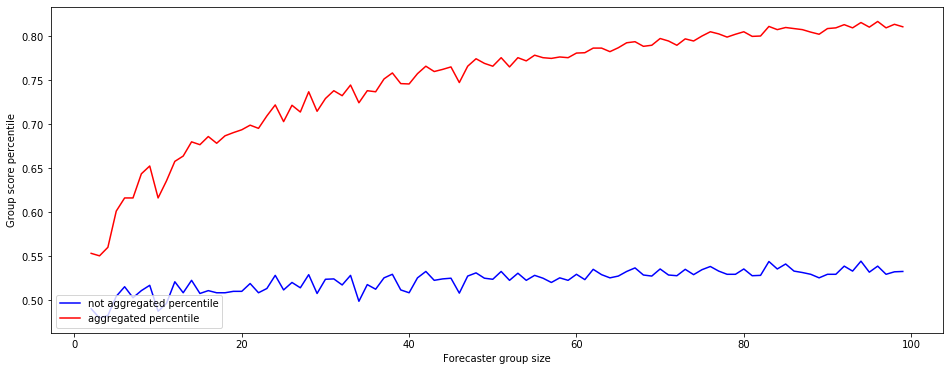

In [12]:
notaggregated=group_scores.loc[group_scores['aggregated']==False].set_index(['size'])
aggregated=group_scores.loc[group_scores['aggregated']==True].set_index(['size'])
fig=plt.figure(figsize=(16,6))
plt.xlabel('Forecaster group size')
plt.ylabel('Group score percentile')
plt.plot(notaggregated['percentile'], color='blue', label='not aggregated percentile')
plt.plot(aggregated['percentile'], color='red', label='aggregated percentile')

plt.legend(loc='lower left')